# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 200)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 200)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 200)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 200), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [20]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 10, 2, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7), dtype=tf.int32, name=None))>

# Creamos la función de costo

In [20]:
from scipy.integrate import solve_ivp
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = tf.random.uniform(shape=(2,), minval=0, maxval=11, dtype=tf.float32)
        y0 = tf.cast(y0, tf.int32)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])

    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [55]:
#model = Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,200)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7)])


In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4000)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 4000)             16000     
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 128)               512128    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                      

# Entrenamos el modelo

In [57]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

In [61]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return 1e-3 - 1e-6*(epoch-100)

In [60]:
val_epochs = 300
tf.compat.v1.global_variables_initializer()

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/300
70/70 [==============================] - 1s 7ms/step - loss: 6.3740 - accuracy: 0.3489 - val_loss: 6.0955 - val_accuracy: 0.3530 - lr: 0.0010
Epoch 2/300
70/70 [==============================] - 1s 8ms/step - loss: 6.2096 - accuracy: 0.3433 - val_loss: 6.4206 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 3/300
70/70 [==============================] - 1s 8ms/step - loss: 6.0961 - accuracy: 0.3504 - val_loss: 5.7150 - val_accuracy: 0.3460 - lr: 0.0010
Epoch 4/300
70/70 [==============================] - 1s 8ms/step - loss: 5.9757 - accuracy: 0.3566 - val_loss: 5.7774 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 5/300
70/70 [==============================] - 1s 8ms/step - loss: 5.9295 - accuracy: 0.3583 - val_loss: 5.6335 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 6/300
70/70 [==============================] - 1s 8ms/step - loss: 5.7722 - accuracy: 0.3594 - val_loss: 5.3760 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 7/300
70/70 [==============================] - 1s 8ms/step - loss: 5.7

Epoch 54/300
70/70 [==============================] - 1s 8ms/step - loss: 4.6561 - accuracy: 0.4640 - val_loss: 4.3405 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 55/300
70/70 [==============================] - 1s 7ms/step - loss: 4.6458 - accuracy: 0.4691 - val_loss: 4.3673 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 56/300
70/70 [==============================] - 1s 8ms/step - loss: 4.6592 - accuracy: 0.4707 - val_loss: 4.3208 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 57/300
70/70 [==============================] - 1s 7ms/step - loss: 4.6396 - accuracy: 0.4649 - val_loss: 4.3637 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 58/300
70/70 [==============================] - 1s 8ms/step - loss: 4.7054 - accuracy: 0.4683 - val_loss: 4.2887 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 59/300
70/70 [==============================] - 1s 7ms/step - loss: 4.5898 - accuracy: 0.4770 - val_loss: 4.2085 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 60/300
70/70 [==============================] - 1s 8ms/step - lo

Epoch 107/300
70/70 [==============================] - 1s 7ms/step - loss: 4.3973 - accuracy: 0.4879 - val_loss: 4.3296 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 108/300
70/70 [==============================] - 1s 8ms/step - loss: 4.3885 - accuracy: 0.4914 - val_loss: 4.3028 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 109/300
70/70 [==============================] - 1s 8ms/step - loss: 4.4111 - accuracy: 0.4900 - val_loss: 4.3233 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 110/300
70/70 [==============================] - 1s 8ms/step - loss: 4.4065 - accuracy: 0.4864 - val_loss: 4.3138 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 111/300
70/70 [==============================] - 1s 8ms/step - loss: 4.3647 - accuracy: 0.4920 - val_loss: 4.2368 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 112/300
70/70 [==============================] - 1s 8ms/step - loss: 4.3624 - accuracy: 0.4991 - val_loss: 4.4054 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 113/300
70/70 [==============================] - 1s 8ms/st

70/70 [==============================] - 1s 8ms/step - loss: 3.7611 - accuracy: 0.5316 - val_loss: 4.5619 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 212/300
70/70 [==============================] - 1s 7ms/step - loss: 3.6933 - accuracy: 0.5321 - val_loss: 4.5671 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 213/300
70/70 [==============================] - 1s 8ms/step - loss: 3.7163 - accuracy: 0.5350 - val_loss: 4.5343 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 214/300
70/70 [==============================] - 1s 7ms/step - loss: 3.7808 - accuracy: 0.5274 - val_loss: 4.6289 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 215/300
70/70 [==============================] - 1s 8ms/step - loss: 3.8062 - accuracy: 0.5274 - val_loss: 4.5811 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 216/300
70/70 [==============================] - 1s 7ms/step - loss: 3.7336 - accuracy: 0.5251 - val_loss: 4.5353 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 217/300
70/70 [==============================] - 1s 8ms/step - loss: 3.7

# Analizamos accuracy y loss

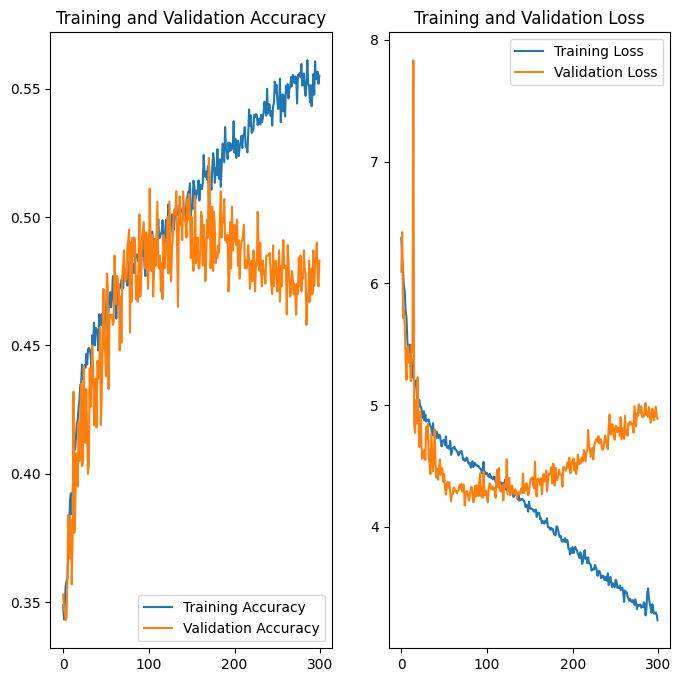

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [63]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../Gráficas finales/historytrayec200.csv', index=False)

# Guardamos el modelo

In [64]:
path_to_save = 'D:/Documentos de trabajo/Maestría/Tesis Maestría/Trabajo Python Tesis/Github Tesis/Modelos/Modelos 100,200'

In [65]:
model.save(path_to_save + '/trayectorias200.h5')

# Importamos el modelo

In [66]:
new_model = keras.models.load_model('../../Modelos/Modelos 100,200/trayectorias200.h5')

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [67]:
import random
from scipy.integrate import solve_ivp

varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)

    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])

        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
    contador = contador+1
    print(contador)

varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[3, 1, 5, 1, 0, 6, 1]
(10, 2, 200)
1


In [68]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [70]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 15ms/step
[[ 7.132368    5.155998   10.178742    5.2787805  -0.75970775 10.003747
   2.4369528 ]]


## Graficamos con los coeficientes reales

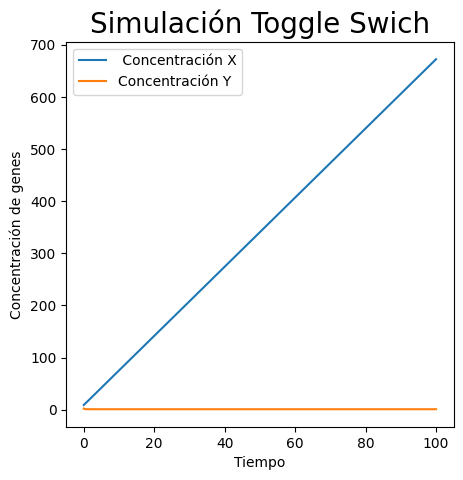

In [71]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
plt.figure(figsize=(5,5))
plt.plot(times,np.array(varf)[0,0,:], label=" Concentración X")
plt.plot(times,np.array(varf)[0,1,:], label="Concentración Y")
plt.xlabel('Tiempo')
plt.ylabel('Concentración de genes')
plt.title('Simulación Toggle Swich', fontsize=20)
plt.legend()
plt.show()

In [72]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

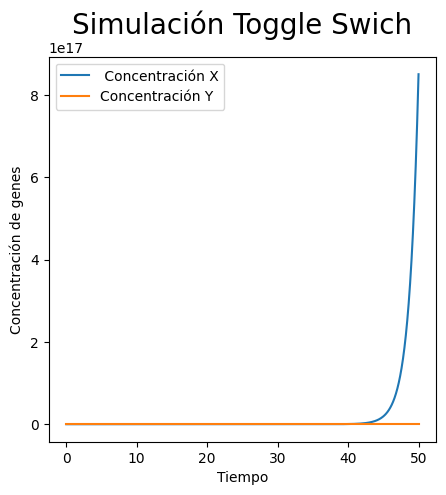

In [73]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)

# Definimos las condiciones iniciales
y0 = np.array([10,10])

# Resolvemos
# Modificar manualmente el intervalo de tiempo
sol = solve_ivp(f, t_span, y0, t_eval=times)
# sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
tiempo = sol.t
var1 = sol.y[0]
var2 = sol.y[1]

# Graficamos
plt.figure(figsize=(5, 5))
plt.plot(tiempo, var1, label=" Concentración X")
plt.plot(tiempo, var2, label="Concentración Y")
plt.xlabel('Tiempo')
plt.ylabel('Concentración de genes')
plt.title('Simulación Toggle Swich', fontsize=20)
plt.legend()
plt.show()